<a href="https://colab.research.google.com/github/Yadukrishnan1/APS2020Tutorial/blob/master/Copy_of_promotional_lift_analysis_7-24-2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings('ignore')

This project is focused on measuring promotional lift using a **counterfactual model**. Let's break down the problem and approach it step by step.

First, let's outline the key components of the problem:

We have *two datasets*:
**daily transactions** and
**promotions data**.

The goal is to **build a model to estimate the lift** (additional units sold) during promotions compared to a baseline.
We need to provide an overall lift estimate with an assessment of uncertainty.


In [ ]:
PATH = '/content/drive/MyDrive/Colab Notebooks/Promotional-Counterfactual/'

In [ ]:
promos = pd.read_csv(os.path.join(PATH, 'promos_new.csv'), engine='pyarrow')
promos.head()

,item_id,promo_type,promo_start_dt,promo_end_dt
0,394930651,PROMO_A,2014-09-04,2014-10-04
1,394914459,PROMO_C,2014-09-25,2014-10-25
2,512317760,PROMO_C,2014-02-04,2014-03-06
3,394851407,PROMO_A,2014-09-28,2014-10-28
4,394904090,PROMO_B,2014-08-29,2014-09-28


In [ ]:
transactions = pd.read_csv(os.path.join(PATH, 'transactions_new.csv'), engine='pyarrow')
transactions.head()

,id,history_date,item_id,price,inventory,sales,category_id
0,133692,2014-08-26,394846296,12.81,183.0,461.16,1
1,134256,2014-08-27,394846296,12.81,183.0,576.45,1
2,134820,2014-08-28,394846296,12.81,183.0,397.11,1
3,135384,2014-08-29,394846296,12.81,183.0,397.11,1
4,135948,2014-08-30,394846296,12.81,183.0,602.07,1


# Data Preprocessing

We merge the promotions data with the weekly transactions. We create a function is_promo_week to determine if a given week was a promotional week for each item.
Additional features are created:

* is_promo: A binary indicator for promotional weeks
* week_of_year: To capture seasonal patterns
* month: Another potential seasonal indicator


We handle **outliers by capping sales at the 99th percentile**. This is a simple approach to prevent extreme values from skewing our model.

Numerical **features are scaled using StandardScaler**. This is important for many machine learning algorithms to ensure all features are on a similar scale.

This preprocessing step gives us a clean, **weekly-aggregated dataset** that includes both transactional and promotional information. The resulting weekly_transactions DataFrame should contain all the necessary information for our analysis and modeling.

In [ ]:
# Convert date columns to datetime
transactions['history_date'] = pd.to_datetime(transactions['history_date'])
promos['promo_start_dt'] = pd.to_datetime(promos['promo_start_dt'])
promos['promo_end_dt'] = pd.to_datetime(promos['promo_end_dt'])

# Impute missing sales data with 0
transactions['sales'] = transactions['sales'].fillna(0)

# Handle negative sales (returns)
# We'll keep the negative values as they should be subtracted in aggregations

# Calculate units sold
transactions['units'] = np.floor(transactions['sales'] / transactions['price'])

# Aggregate data to weekly level
transactions['week'] = transactions['history_date'].dt.to_period('W')
weekly_transactions = transactions.groupby(['week', 'item_id', 'category_id']).agg({
    'price': 'mean',
    'inventory': 'mean',
    'sales': 'sum',
    'units': 'sum'
}).reset_index()

weekly_transactions.head()


,week,item_id,category_id,price,inventory,sales,units
0,2013-12-30/2014-01-05,394846541,3,80.39,161.0,26930.65,335.0
1,2013-12-30/2014-01-05,394848103,5,75.82,372.6,24944.78,329.0
2,2013-12-30/2014-01-05,394848110,2,240.57,106.4,47151.72,196.0
3,2013-12-30/2014-01-05,394848314,1,31.48,369.6,6233.04,198.0
4,2013-12-30/2014-01-05,394848615,2,58.07,374.0,12426.98,214.0


In [ ]:
# Merge promotions data
weekly_transactions['week_start'] = weekly_transactions['week'].dt.start_time
weekly_transactions['week_end'] = weekly_transactions['week'].dt.end_time

def is_promo_week(row, promos_df):
    item_promos = promos_df[promos_df['item_id'] == row['item_id']]
    for _, promo in item_promos.iterrows():
        if (row['week_start'] <= promo['promo_end_dt'] and row['week_end'] >= promo['promo_start_dt']):
            return promo['promo_type']
    return 'NONPROMO'

weekly_transactions['promo_type'] = weekly_transactions.apply(lambda row: is_promo_week(row, promos), axis=1)

# Create additional features
weekly_transactions['is_promo'] = (weekly_transactions['promo_type'] != 'NONPROMO').astype(int)
weekly_transactions['week_of_year'] = weekly_transactions['week'].dt.week
weekly_transactions['month'] = weekly_transactions['week'].dt.month

# Handle outliers (example: capping sales at 99th percentile)
sales_cap = weekly_transactions['sales'].quantile(0.99)
weekly_transactions['sales'] = weekly_transactions['sales'].clip(upper=sales_cap)
weekly_transactions.head()

,week,item_id,category_id,price,inventory,sales,units,week_start,week_end,promo_type,is_promo,week_of_year,month
0,2013-12-30/2014-01-05,394846541,3,80.39,161.0,26930.65,335.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
1,2013-12-30/2014-01-05,394848103,5,75.82,372.6,24944.78,329.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
2,2013-12-30/2014-01-05,394848110,2,240.57,106.4,47151.72,196.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
3,2013-12-30/2014-01-05,394848314,1,31.48,369.6,6233.04,198.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
4,2013-12-30/2014-01-05,394848615,2,58.07,374.0,12426.98,214.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1


In [ ]:
## Scale numerical features
#from sklearn.preprocessing import StandardScaler
#
#scaler = StandardScaler()
#numerical_features = ['price', 'inventory', 'sales_capped']
#weekly_transactions[numerical_features] = scaler.fit_transform(weekly_transactions[numerical_features])
#
## Print the first few rows of the processed dataset
#weekly_transactions.head(10)

,week,item_id,category_id,price,inventory,sales,units,week_start,week_end,promo_type,is_promo,week_of_year,month
0,2013-12-30/2014-01-05,394846541,3,80.39,161.0,26930.65,335.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
1,2013-12-30/2014-01-05,394848103,5,75.82,372.6,24944.78,329.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
2,2013-12-30/2014-01-05,394848110,2,240.57,106.4,47151.72,196.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
3,2013-12-30/2014-01-05,394848314,1,31.48,369.6,6233.04,198.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
4,2013-12-30/2014-01-05,394848615,2,58.07,374.0,12426.98,214.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1


# **EDA**

## Key insights to look for:

1. Do promotions generally increase sales? Look at the box plot and t-test results.
2. Which categories seem to benefit most from promotions? Check the promotional lift by category plot.
3. Is there a strong relationship between price and sales? Examine the scatter plot and correlation matrix.
4. Are there clear seasonal patterns in sales? The week of year plot will show this.
5. Do different promotion types have varying levels of effectiveness? Compare the summary statistics.

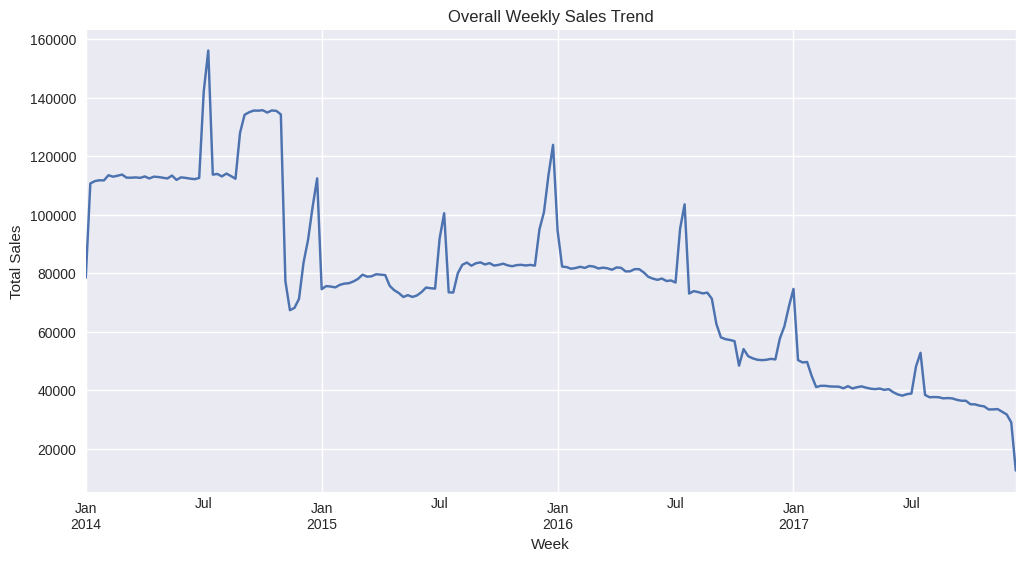

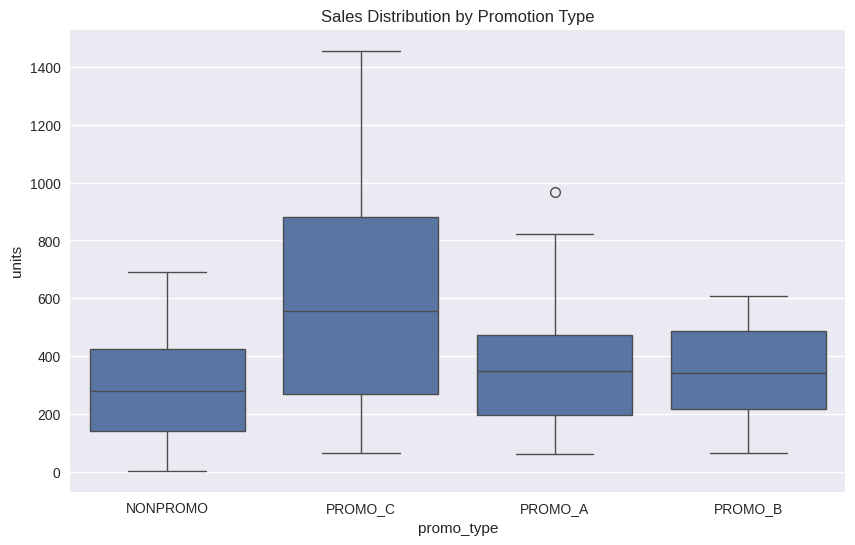

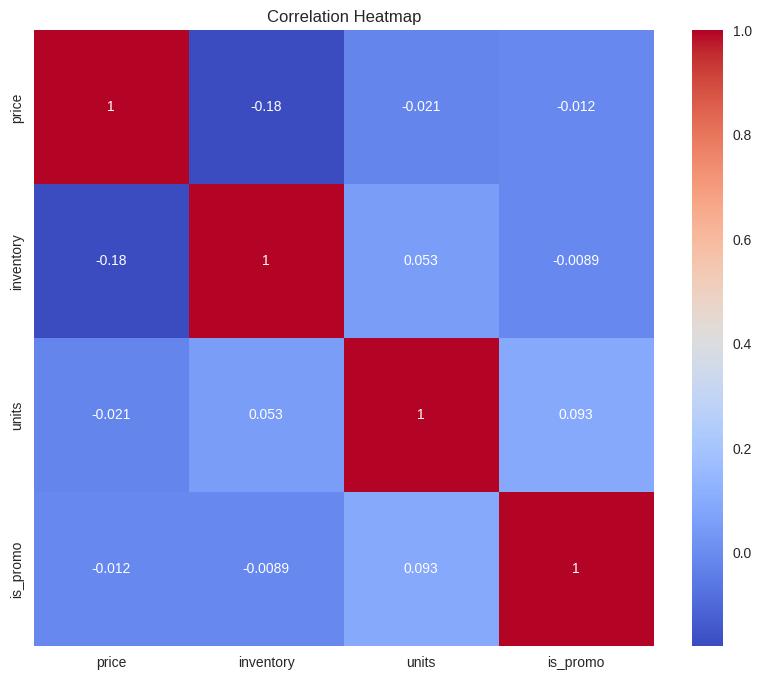

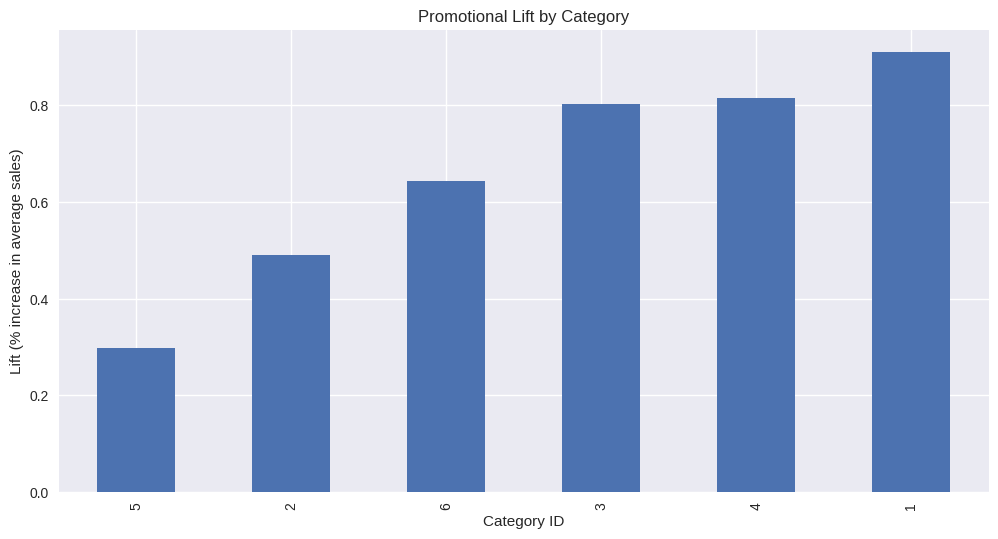

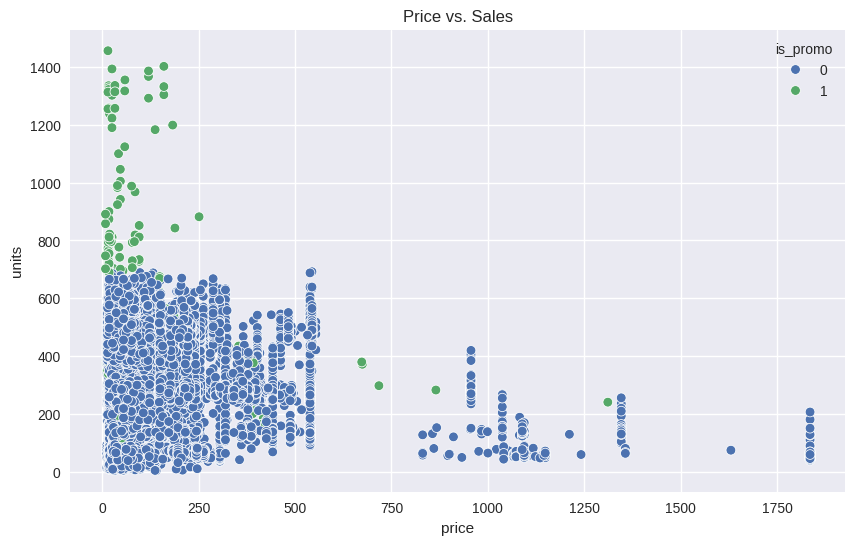

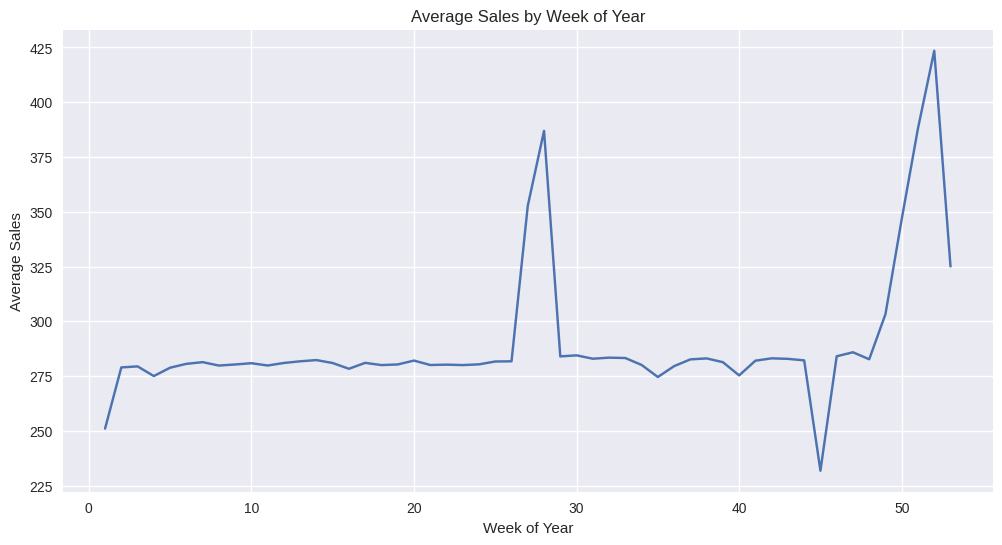

Summary Statistics by Promotion Type:
                   sales                                   units         \
                    mean        median           std        mean median   
promo_type                                                                
NONPROMO    27716.685619  14550.810000  33922.423142  286.365627  281.0   
PROMO_A     31169.240701  15936.969573  37383.507400  366.473214  347.5   
PROMO_B     26638.693893  15406.738806  38183.513130  351.753521  341.0   
PROMO_C     38213.613504  13447.684895  50870.469759  625.055172  555.0   

                             price                      
                   std        mean  median         std  
promo_type                                              
NONPROMO    150.848091  100.164864  58.070  130.402657  
PROMO_A     220.797325   85.284566  46.456  103.225206  
PROMO_B     154.312117   76.097072  44.600  106.472540  
PROMO_C     407.665266   84.970886  39.485  165.060444  

T-test results for promotional impac

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assuming weekly_transactions is our preprocessed dataset

# Set the style for our plots
plt.style.use('seaborn')

# 1. Overall sales trends
plt.figure(figsize=(12, 6))
weekly_transactions.groupby('week')['units'].sum().plot()
plt.title('Overall Weekly Sales Trend')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.show()

# 2. Promotional impact on sales
plt.figure(figsize=(10, 6))
sns.boxplot(x='promo_type', y='units', data=weekly_transactions)
plt.title('Sales Distribution by Promotion Type')
plt.show()

# 3. Correlation heatmap
correlation_matrix = weekly_transactions[['price', 'inventory', 'units', 'is_promo']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

# 5. Promotional effectiveness by category
promo_effect = weekly_transactions.groupby(['category_id', 'is_promo'])['units'].mean().unstack()
promo_effect['lift'] = (promo_effect[1] - promo_effect[0]) / promo_effect[0]
plt.figure(figsize=(12, 6))
promo_effect['lift'].sort_values().plot(kind='bar')
plt.title('Promotional Lift by Category')
plt.xlabel('Category ID')
plt.ylabel('Lift (% increase in average sales)')
plt.show()

# 6. Price vs. Sales scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='price', y='units', hue='is_promo', data=weekly_transactions)
plt.title('Price vs. Sales')
plt.show()

# 7. Seasonal patterns
plt.figure(figsize=(12, 6))
weekly_transactions.groupby('week_of_year')['units'].mean().plot()
plt.title('Average Sales by Week of Year')
plt.xlabel('Week of Year')
plt.ylabel('Average Sales')
plt.show()

# 8. Summary statistics
summary_stats = weekly_transactions.groupby('promo_type').agg({
    'sales': ['mean', 'median', 'std'],
    'units': ['mean', 'median', 'std'],
    'price': ['mean', 'median', 'std']
})
print("Summary Statistics by Promotion Type:")
print(summary_stats)

# 9. T-test for promotional impact
promo_sales = weekly_transactions[weekly_transactions['is_promo'] == 1]['units']
non_promo_sales = weekly_transactions[weekly_transactions['is_promo'] == 0]['units']
t_stat, p_value = stats.ttest_ind(promo_sales, non_promo_sales)
print(f"\nT-test results for promotional impact on sales:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

* The standard scaling should be used after the train-test split
*

In [ ]:
fav_item_weekly_transactions = weekly_transactions[weekly_transactions['item_id']==512464642]

fav_item_weekly_transactions.head()

,week,item_id,category_id,price,inventory,sales,units,week_start,week_end,promo_type,is_promo,week_of_year,month
377,2013-12-30/2014-01-05,512464642,4,57.1,95.0,2455.3,43.0,2013-12-30,2014-01-05 23:59:59.999999999,NONPROMO,0,1,1
783,2014-01-06/2014-01-12,512464642,4,57.1,90.0,4853.5,85.0,2014-01-06,2014-01-12 23:59:59.999999999,NONPROMO,0,2,1
1189,2014-01-13/2014-01-19,512464642,4,57.1,88.0,2569.5,45.0,2014-01-13,2014-01-19 23:59:59.999999999,NONPROMO,0,3,1
1597,2014-01-20/2014-01-26,512464642,4,57.1,88.0,2855.0,50.0,2014-01-20,2014-01-26 23:59:59.999999999,NONPROMO,0,4,1
2006,2014-01-27/2014-02-02,512464642,4,57.1,88.0,3825.7,67.0,2014-01-27,2014-02-02 23:59:59.999999999,NONPROMO,0,5,2


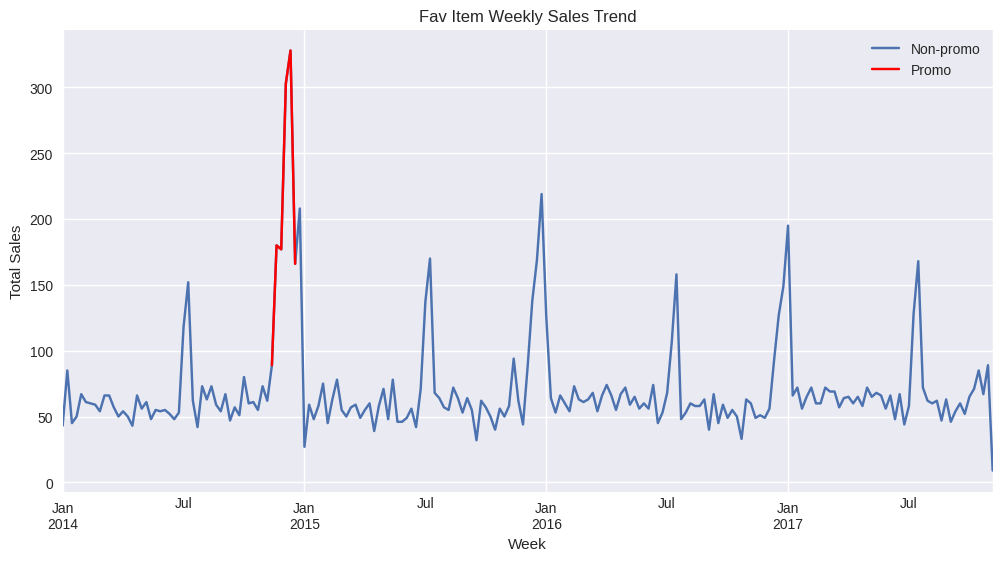

In [ ]:

# plot a timeseries of units from fav_item_weekly_transactions. Show a shaded region for when the promo_type was 1.

plt.figure(figsize=(12, 6))
fav_item_weekly_transactions.groupby('week')['units'].sum().plot(label='Non-promo')
fav_item_weekly_transactions[fav_item_weekly_transactions['is_promo'] == 1].groupby('week')['units'].sum().plot(color='r', label='Promo')
plt.title('Fav Item Weekly Sales Trend')
plt.xlabel('Week')
plt.ylabel('Total Sales')
plt.legend()
plt.show()





# Model Building

Let's move on to the model building phase. Based on our exploratory data analysis, we'll now create a model using TensorFlow. We'll use the Estimator API and choose a model that can capture both linear and non-linear relationships in our data.

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Assuming weekly_transactions is our preprocessed dataset
# If not, we would need to run the preprocessing code first

# Convert category_id to string
weekly_transactions['category_id'] = weekly_transactions['category_id'].astype(str)

# Update the features list to include 'category_id' and 'promo_type'
features = ['price', 'inventory', 'week_of_year', 'month', 'is_promo', 'category_id', 'promo_type']
target = 'units'

X = weekly_transactions[features]
y = weekly_transactions[target]

# Create categorical columns
category_column = tf.feature_column.categorical_column_with_vocabulary_list(
    'category_id', vocabulary_list=weekly_transactions['category_id'].unique())
promo_type_column = tf.feature_column.categorical_column_with_vocabulary_list(
    'promo_type', vocabulary_list=weekly_transactions['promo_type'].unique())

# Create feature columns
feature_columns = [
    tf.feature_column.numeric_column('price'),
    tf.feature_column.numeric_column('inventory'),
    tf.feature_column.numeric_column('week_of_year'),
    tf.feature_column.numeric_column('month'),
    tf.feature_column.numeric_column('is_promo'),
    tf.feature_column.indicator_column(category_column),
    tf.feature_column.indicator_column(promo_type_column)
]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create input functions
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(1000)
        dataset = dataset.repeat(n_epochs)
        dataset = dataset.batch(32)
        return dataset
    return input_fn

train_input_fn = make_input_fn(X_train, y_train)
eval_input_fn = make_input_fn(X_test, y_test, shuffle=False, n_epochs=1)

# Create the model (with legacy optimizer)
model = tf.estimator.DNNLinearCombinedRegressor(
    model_dir='./model_dir',
    linear_feature_columns=feature_columns,
    dnn_feature_columns=feature_columns,
    dnn_hidden_units=[64, 32],
    dnn_optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
)

# Train the model
model.train(input_fn=train_input_fn, steps=500)

# Evaluate the model
eval_result = model.evaluate(input_fn=eval_input_fn)
print("Evaluation results:", eval_result)

# Make predictions
predictions = model.predict(input_fn=eval_input_fn)


Instructions for updating:
Use standard file utilities to get mtimes.


Evaluation results: {'average_loss': 2179.571, 'label/mean': 286.35602, 'loss': 2178.2134, 'prediction/mean': 297.2942, 'global_step': 1500}


# Do from here.

In [ ]:

# Updated function to calculate lift
def calculate_lift(row, model):
    # Create a DataFrame with a single row for the promotional case
    promo_df = pd.DataFrame([row])

    # Create a copy for the non-promotional case
    nonpromo_df = promo_df.copy()
    nonpromo_df['promo_type'] = 'NONPROMO'
    nonpromo_df['is_promo'] = 0

    # Create input functions for both cases
    promo_input_fn = lambda: tf.data.Dataset.from_tensor_slices((dict(promo_df), [0])).batch(100)
    nonpromo_input_fn = lambda: tf.data.Dataset.from_tensor_slices((dict(nonpromo_df), [0])).batch(100)

    # Get predictions
    promo_prediction = next(model.predict(input_fn=promo_input_fn))['predictions'][0]
    nonpromo_prediction = next(model.predict(input_fn=nonpromo_input_fn))['predictions'][0]

    # Calculate and return lift
    return (promo_prediction - nonpromo_prediction) / nonpromo_prediction

# Calculate lift for each row in test set
X_test['lift'] = X_test.apply(lambda row: calculate_lift(row, model), axis=1)

# Calculate overall lift and confidence interval
mean_lift = X_test['lift'].mean()
confidence_interval = 1.96 * X_test['lift'].std() / np.sqrt(len(X_test))

print(f"Overall lift: {mean_lift:.2f}")
print(f"90% Confidence Interval: ({mean_lift - confidence_interval:.2f}, {mean_lift + confidence_interval:.2f})")


In [ ]:

# Calculate lift by product and promotion type
lift_by_product_promo = X_test.groupby(['item_id', 'promo_type'])['lift'].agg(['mean', 'std']).reset_index()
lift_by_product_promo['ci'] = 1.96 * lift_by_product_promo['std'] / np.sqrt(lift_by_product_promo.groupby(['item_id', 'promo_type']).transform('count')['mean'])
print(lift_by_product_promo)

# Save the results for later visualization
lift_by_product_promo.to_csv('lift_by_product_promo.csv', index=False)

Let's interpret these visualizations and results:

*Overall lift distribution: This histogram shows how lift is distributed across all product-promotion combinations. We can see if the lift is generally positive and how it's spread.

*Lift by promotion type: This boxplot allows us to compare the effectiveness of different promotion types. We can identify which types tend to produce higher lifts.

*Top 10 products with highest lift: This bar chart highlights the products that respond best to promotions overall. These might be candidates for more frequent promotions.

*Lift vs. Confidence Interval: This scatter plot helps us understand the relationship between the magnitude of lift and our certainty about it. Points with high lift and low CI are our most reliable results.

*Heatmap of lift by product and promotion type: This gives us a comprehensive view of how different products respond to different promotion types. Darker colors indicate higher lift.

*The summary statistics and top/bottom 5 lists give us quick insights into the range of lift values and specific product-promotion combinations that stand out.
Key points to consider in our interpretation:

*Overall effectiveness: Is the average lift positive? This tells us if promotions are generally effective.

*Variation in effectiveness: How much do lifts vary across products and promotion types? This indicates if we need targeted strategies or if a one-size-fits-all approach might work.

*Best performers: Which products and promotion types consistently show high lift? These are candidates for more frequent or expanded promotions.

*Underperformers: Are there products or promotion types that consistently show low or negative lift? We might want to reconsider these or investigate why they're not effective.

*Confidence in results: How wide are the confidence intervals, especially for high-lift results? This helps us understand how reliable our findings are.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the results
lift_by_product_promo = pd.read_csv('lift_by_product_promo.csv')

# 1. Overall lift distribution
plt.figure(figsize=(10, 6))
sns.histplot(lift_by_product_promo['mean'], kde=True)
plt.title('Distribution of Lift Across Products and Promotions')
plt.xlabel('Lift')
plt.ylabel('Count')
plt.show()

# 2. Lift by promotion type
plt.figure(figsize=(12, 6))
sns.boxplot(x='promo_type', y='mean', data=lift_by_product_promo)
plt.title('Lift by Promotion Type')
plt.xlabel('Promotion Type')
plt.ylabel('Lift')
plt.show()

# 3. Top 10 products with highest lift
top_10_products = lift_by_product_promo.groupby('item_id')['mean'].mean().nlargest(10).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='item_id', y='mean', data=top_10_products)
plt.title('Top 10 Products with Highest Average Lift')
plt.xlabel('Product ID')
plt.ylabel('Average Lift')
plt.xticks(rotation=45)
plt.show()

# 4. Lift vs. Confidence Interval
plt.figure(figsize=(10, 6))
plt.scatter(lift_by_product_promo['mean'], lift_by_product_promo['ci'])
plt.title('Lift vs. Confidence Interval')
plt.xlabel('Lift')
plt.ylabel('Confidence Interval')
plt.show()

# 5. Heatmap of lift by product and promotion type
pivot_lift = lift_by_product_promo.pivot(index='item_id', columns='promo_type', values='mean')
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_lift, cmap='YlOrRd')
plt.title('Heatmap of Lift by Product and Promotion Type')
plt.show()

print("Overall summary statistics:")
print(lift_by_product_promo['mean'].describe())

print("\nTop 5 product-promotion combinations:")
print(lift_by_product_promo.nlargest(5, 'mean')[['item_id', 'promo_type', 'mean', 'ci']])

print("\nBottom 5 product-promotion combinations:")
print(lift_by_product_promo.nsmallest(5, 'mean')[['item_id', 'promo_type', 'mean', 'ci']])